# Introduction

This notebook demonstrates typical initial steps to exploring phenotype distributions. It has been written to be interactive, allowing you to make choices as you go.

## Data disclaimer
----

All data in this notebook (and this workspace) are publicly available thanks to the effort of many dedicated individuals: 

- Genotype and some phenotypic data were produced by the [1000 Genomes Project (phase 3)](https://www.internationalgenome.org/)

- Individual phenotypes were modeling using the [GCTA software](cnsgenomics.com/software/gcta) and variant-level summary statistics from [MAGIC](https://www.magicinvestigators.org/), the [GIANT Consortium](https://portals.broadinstitute.org/collaboration/giant/index.php/Main_Page), the [UK Biobank](https://www.ukbiobank.ac.uk/), and the [MVP](https://www.research.va.gov/mvp/)  

Phenotypes were modeled to reflect the actual genetic architecture of these complex traits as closely as possible. Most single variant association results should correspond well to published GWAS, but others may not. **Results produced from these data should not be taken as representing real, replicable genetic associations. These data are provided for demonstration and training purposes only.**

## Load Python packages
----

* **Pandas & Numpy** - packages for data analysis  
* **Pprint** - for pretty printing  
* **Matplotlib & Seaborn** - for plotting  

To see the entire list of Python packages, click the purple arrow to the right below.

In [1]:
%%capture 
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

# Load phenotypes 

Phenotypic data for each individual in the study are stored locally in a CSV file. To analyze inside this notebook, we have to explicitly load the data in our notebook environment. 

## Load phenotype data

We'll use <font color='red'>read_csv</font> to load the phenotypes from a CSV file. The columns correspond to:  

* **sample:** a unique label for each individual sample in our dataset
* **age:** numerical age of the individual at the time of each phenotype measure
* **ancestry:** superpopulation group of each individual
  * AFR: African
  * AMR: Ad Mixed American
  * EAS: East Asian
  * EUR: European
  * SAS: South Asian
* **bmi:** body mass index
* **fg:** fasting glucose
* **fi:** fasting insulin
* **hdl:** high density lipoprotein
* **height:** standing height
* **ldl:** low density lipoprotein
* **population:** population of each sample, see [1000 Genomes description](https://www.internationalgenome.org/category/population/)
* **sex:** biological sex
* **tc:** total cholesteral
* **tg:** total triglycerides
* **whr:** waist-to-hip ratio


In [2]:
# remember to change the workspace bucket ID in the code below
# !gsutil cp gs://your-workspace-bucket-id/your-CSV-file-name.txt .

!gsutil cp gs://fc-25187567-7377-4b5f-8e64-fa21b1363d1d/demo-pheno-data.txt .

Copying gs://fc-25187567-7377-4b5f-8e64-fa21b1363d1d/demo-pheno-data.txt...
/ [1 files][263.4 KiB/263.4 KiB]                                                
Operation completed over 1 objects/263.4 KiB.                                    


In [3]:
# Check if the file is in the Cloud Environment VM
! ls

demo-pheno-data.txt		  pheno-data-demo-v2.ipynb
gpu_tests_verily_01.ipynb	  scVI-test.ipynb
ML_Test_1.ipynb			  tensorflow_test_01.ipynb
ML_Test_Torch.ipynb		  Test_02.ipynb
pheno-data-demo.ipynb		  torch-test.ipynb
pheno-data-demo-v1-updated.ipynb


In [4]:
# Get all of the phenotype data and load into a pandas dataframe
samples = pd.read_csv("demo-pheno-data.txt", sep='\t')
samples.rename(columns = {'entity:sample_id':'sample'}, inplace = True)

# Take a look at the top of our table
samples.head()

,pheno-data-id,age,bmi_baseline,dbgap_accession_number,height_baseline,ldl,lhdl,population,program_name,sample_specimen_id,sex,total_cholesterol,triglycerides
0,HG00096,75,25.3,synthetic_data_set_1,181.9,105.968,91.179,GBR,tutorial,HG00096_sample,male,243.646,62.498
1,HG00097,63,26.9,synthetic_data_set_1,171.4,114.580,60.695,GBR,tutorial,HG00097_sample,female,356.595,197.320
2,HG00099,48,23.9,synthetic_data_set_1,187.7,52.246,56.254,GBR,tutorial,HG00099_sample,female,263.123,170.623
3,HG00100,46,24.3,synthetic_data_set_1,174.6,88.706,63.895,GBR,tutorial,HG00100_sample,female,255.708,119.108
4,HG00101,37,24.9,synthetic_data_set_1,176.0,109.677,85.614,GBR,tutorial,HG00101_sample,male,226.317,47.026


In [5]:
! ls

demo-pheno-data.txt		  pheno-data-demo-v2.ipynb
gpu_tests_verily_01.ipynb	  scVI-test.ipynb
ML_Test_1.ipynb			  tensorflow_test_01.ipynb
ML_Test_Torch.ipynb		  Test_02.ipynb
pheno-data-demo.ipynb		  torch-test.ipynb
pheno-data-demo-v1-updated.ipynb


# Examine phenotype data
----

Let's take a look at the phenotype distributions. In a GWAS - and statistical genetics more generally - we should always be on the lookout for correlations within our dataset. Correlations between phenotypic values can confound our analysis, leading to results that may not represent true genetic associations with our traits. Exploring these relationships may help in choosing a reasonable set of covariates to model.    

We've included a number of plotting functions below to make this as easy as possible. Feel free to modify - or write your own functions - as you explore the data. 


## Goals of this section
----
    
1. Visualize the distribution of phenotype values  
    - Within each continuous trait (using the kdplot function)  
    - Within each continuous trait, organized by dichotomous data (ex: the distribution of BMI in each ancestry group - using the boxPlot function)  
    - Between two continuous traits (with the bivariateDistributionPlot function)
2. Determine whether trait distributions follow patterns we might expect

## Code for plotting functions
    
The next code block defines the plotting functions. Because running the plotting functions doesn't require understanding the syntax of the code, we have collapsed this block. Feel free to uncollapse (click the purple arrow at the right) if you're interested in all the details!

In [6]:
# Define functions to easily plot phenotypes
plt.rcParams["figure.figsize"] = [6,4]
    
# Visualize distribution with each continuous trait
def kdPlot(data, var):
    sns.set_style("whitegrid")
    sns.set_context("poster", 
                    font_scale = 0.9, 
                    rc={"grid.linewidth": 0.6, 'lines.linewidth': 1.6})
    sns.distplot(data[(var)])
    
# Visualize the distribution between two continuous traits
def bivariateDistributionPlot(data, var1, var2, kind = "scatter"):
    with sns.axes_style("whitegrid"):
        jplot = sns.jointplot(x = data[var1], y = data[var2], kind=kind, color="k", s=1)
        jplot.set_axis_labels(var1, var2)
        
# Visualize within each continuous trait, organized by dichotomous data
def boxPlot(data, catagorical_var, continuous_var, color_by = None, force_x = False, force_color = False):
    make_plot = True
    if len(data[catagorical_var].unique().tolist()) > 10 and force_x is not True:
        make_plot = False
        print("catagorical_var must be catagorical. If you insist on using these x values, set force_x = True.")
    if color_by is not None:
        if len(data[color_by].unique()) > 5 and force_color is not True:
            make_plot = False
            print("color_by column must be catagorical. If you insist on using these values, set force_color = True.")
    
    if (make_plot is True):
        sns.set_style("whitegrid")
        sns.set_context("poster", 
                        font_scale = 0.7, 
                        rc={"grid.linewidth": 0.6, 'lines.linewidth': 1.6})
        sns.boxplot(x = catagorical_var, 
                    y = continuous_var, 
                    hue = color_by, 
                    data = data, 
                    palette = ["#275F9A", "#A2C353"],
                    saturation = 1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Generating distribution plots

<img src="https://raw.githubusercontent.com/tmajaria/ashg_2019_workshop/master/ldl_kdplot.png" align="left" width="20%">

***Univariate distributions*** are easily visualized in histograms or density plots. We provide a function (<font color='red'>kdplot</font>) that will generate both types of plots, overlayed in a single figure. A continuously-valued variable corresponding to a column in the phenotype dataframe should be used as input, *ldl* in this example. The function is called with the following syntax:

```python
kdPlot(samples, var = "ldl")
```

<img src="https://raw.githubusercontent.com/tmajaria/ashg_2019_workshop/master/whr_hdl_bivariateDistributionPlot.png" align="left" width="20%"> 

***Bivariate distributions*** can be visualized using a scatterplot. Use the function <font color='red'>bivariateDistributionPlot</font> to visualize two continuously values variables. The *type* argument determines the type of plot generated and can be one of: "scatter", "reg", "resid", "kde", and "hex".

```python
bivariateDistributionPlot(samples, var1 = "hdl", var2 = "whr", kind = "scatter")
```

<img src="https://raw.githubusercontent.com/tmajaria/ashg_2019_workshop/master/height_ancestry_boxPlot.png" align="left" width="20%">

***Boxplots*** can be used to further interogate relationships between continuous and categorical variables, using the <font color='red'>boxPlot</font> function. Distributions can be further subset by sex (by setting *color_by* = "sex").

```python
boxPlot(samples, catagorical_var = "population", continuous_var = "height", color_by = "sex")
```

### Exercise: Univariate distributions

Use the code cells below to plot the distribution of single variables of your choice (such as ldl or bmi). You may need to refer to section 3.2 above for the list of variables and to section 4.1 for the plotting syntax. 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


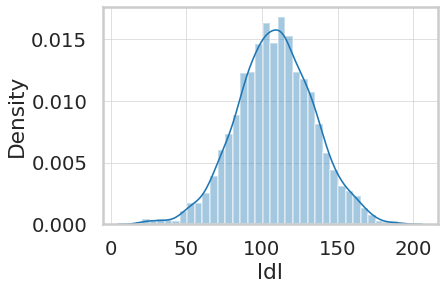

In [7]:
kdPlot(samples, var = "ldl")

### Exercise: Bivariate distributions

Generate scatter plots with different combinations of variables. Think about what you would expect versus what you see in the plot. You may need to refer to 3.2 for the list of variables and to section 4.1 for the plotting syntax. 

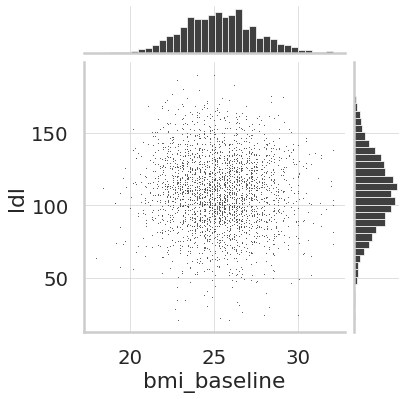

In [8]:
bivariateDistributionPlot(samples, var1 = "bmi_baseline", var2 = "ldl", kind = "scatter")

### Exercise: Boxplots 

Boxplots show relationships between continuous and categorical variables. Use the code cell below to generate a boxplot showing the relationship between height and ancestry. Try adding sex as another delineator with the `color_by` argument. You may need to refer to 3.2 for the list of variables and to section 4.1 for the plotting syntax.

In the next code block, try a boxplot with variables of your choice.

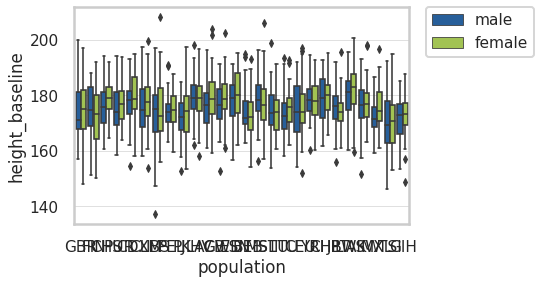

In [9]:
boxPlot(samples, catagorical_var = "population", continuous_var = "height_baseline", color_by = "sex", force_x = True)